<a href="https://colab.research.google.com/github/taimoorsardar/Deep-Learning-Projects/blob/main/GenerativeAdversarialNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing necessary packages
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
DEVICE = 'cuda' # used to tranfer tensors to gpu

# generator model parameter
NOISE_DIM = 64 # shape of random noise vec given in above diagram

# optimizers parameters
LR = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training parameters
EPOCHS = 20
BATCH_SIZE = 128 # trainloader parameter as well

# Load MNIST Dataset

In [ ]:
# This dataset is available in torchvision dataset packages
from torchvision import datasets, transforms as T

In [ ]:
# defining a fucntion for augmentation of training data
def get_train_augs():
  return T.Compose([
      T.RandomRotation((-20, +20)),
      # bcoz images will be in numpy or other type, so we convert it back to tensor
      T.ToTensor()  # (h,w,c) -> (c,h,w)
  ])

In [ ]:
from matplotlib import transforms
# loading the dataset MNIST
trainset = datasets.MNIST('MNIST/', download = True, train = True,transform = get_train_augs())

"image, label = trainset[43]\nplt.imshow(image.squeeze(), cmap = 'gray')"

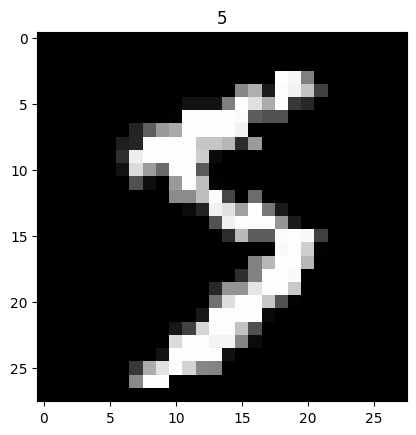

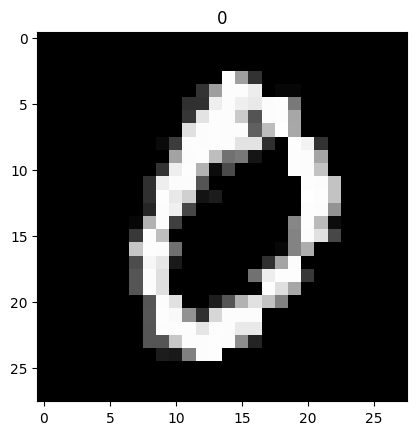

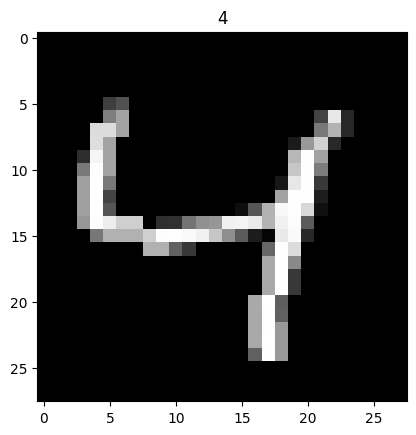

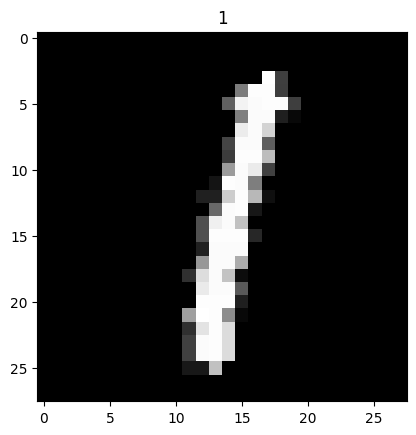

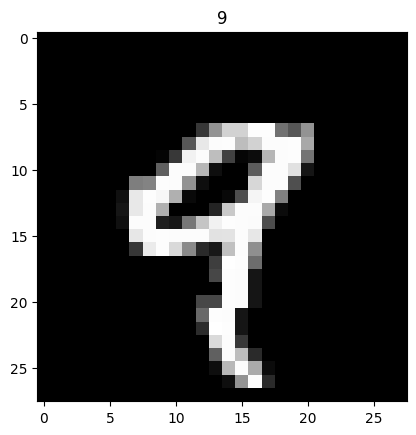

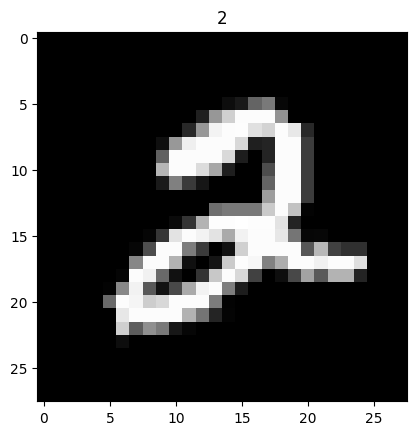

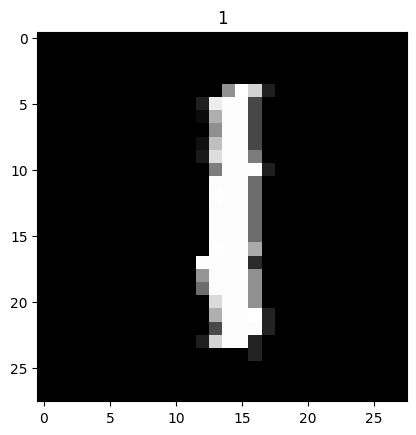

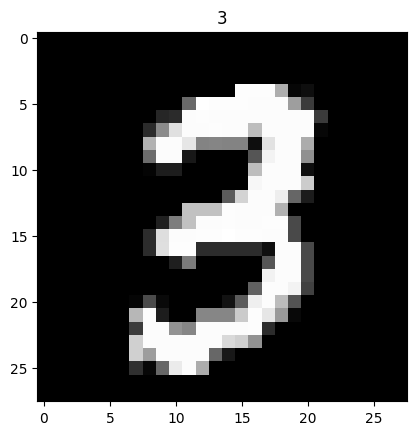

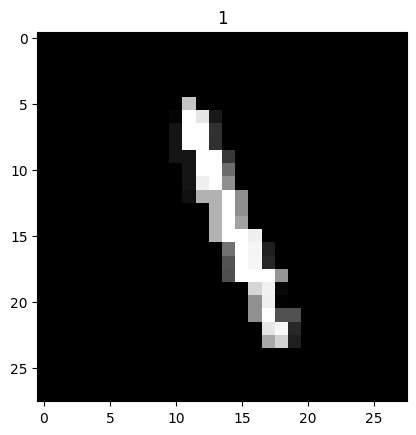

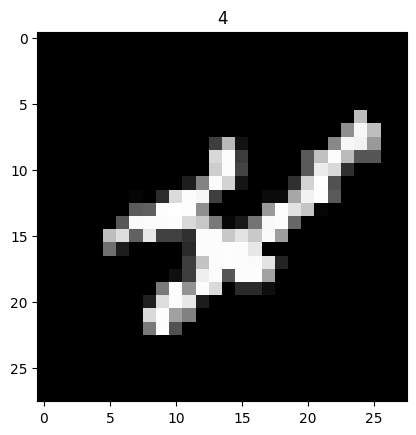

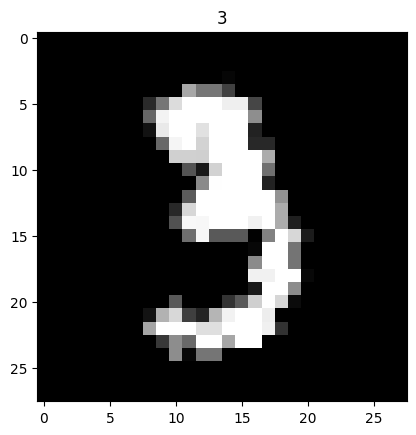

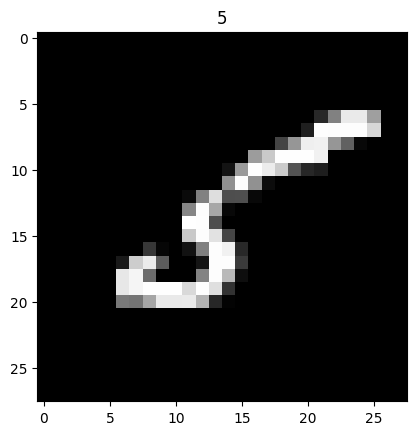

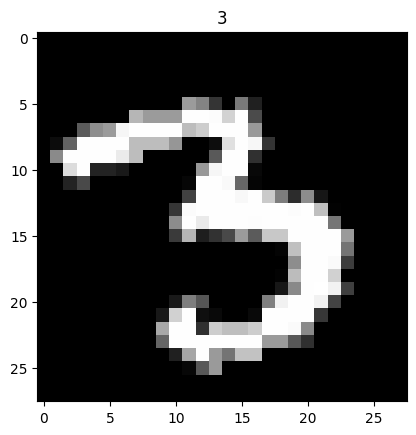

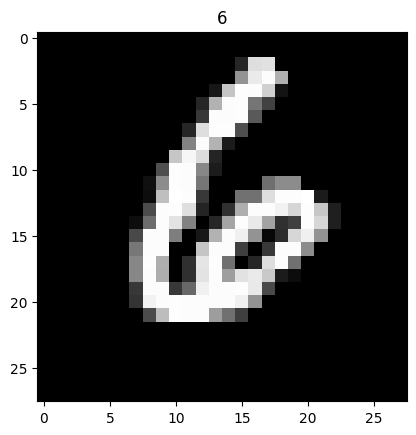

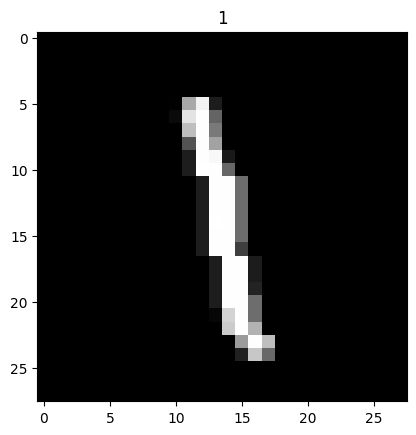

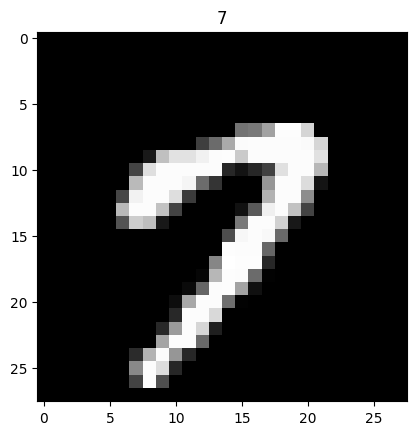

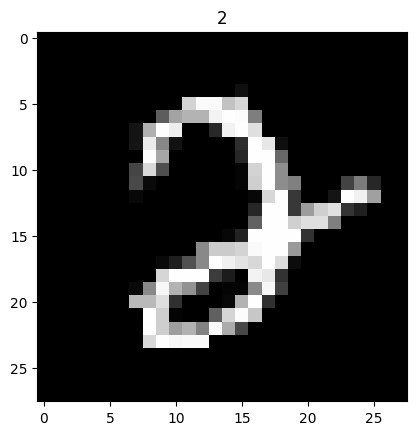

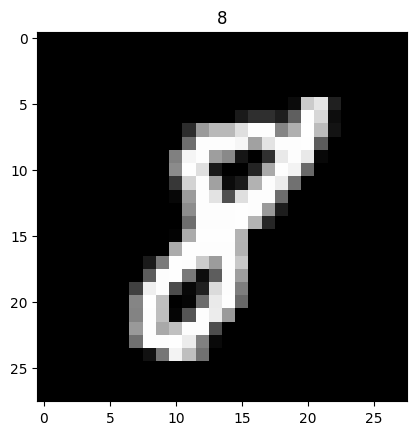

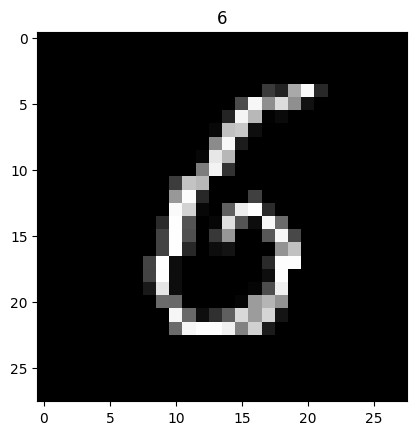

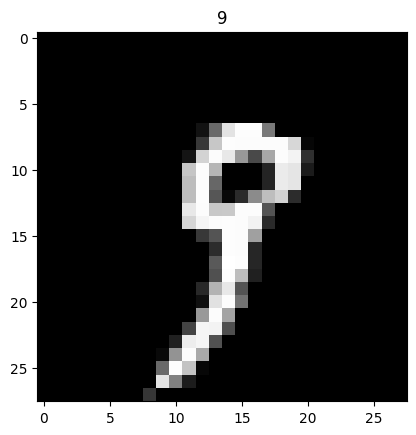

In [ ]:
# lets check some of the images in trainset
for i in range(0,20):
  image, label = trainset[i]
  plt.figure()
  plt.imshow(image.squeeze(), cmap = 'gray')
  plt.title(label)
'''image, label = trainset[43]
plt.imshow(image.squeeze(), cmap = 'gray')'''

In [ ]:
print("Length of trainset : ", len(trainset))

Length of trainset :  60000


# Load Dataset Into Batches
in this part we will divide our dataset into batches using "DataLoader"

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid # useful for plotting multiple images

In [ ]:
#from torch.nn.parallel.data_parallel import device
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
for data in trainloader:
  image, label = data
  image.to(DEVICE)
  label.to(DEVICE)

In [ ]:
print("Total No. of batches in trainloader : ", len(trainloader))

Total No. of batches in trainloader :  469


In [ ]:
# lets check our data now
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

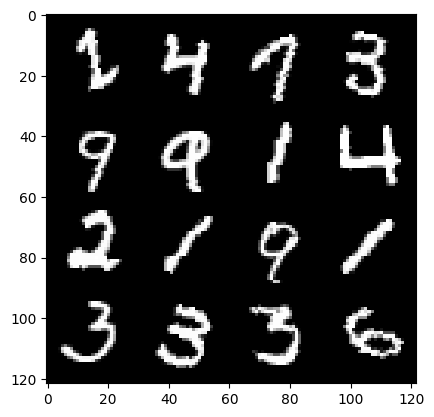

In [ ]:
show_tensor_images(images,16)

# Create Discriminator Network
identifies whether image is real or not


In [ ]:
#In case if torch summary is not installed
!pip install torchsummary

In [ ]:
# import necessary libraries
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''
''' as blocks are going to be same so we'll make a function so we can easily
write a discriminator block
but the input channels, output channels, kernel size, stride are going
to be different
'''

" as blocks are going to be same so we'll make a function so we can easily\nwrite a discriminator block\nbut the input channels, output channels, kernel size, stride are going\nto be different\n"

In [ ]:
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.batchnorm import BatchNorm1d
def get_disc_block(in_channels, out_channels, kernel_size, stride,):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      LeakyReLU(0.2) # here 0.2 is lower limit
  )

Lets create our discriminator model

In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self,images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [ ]:
# lets check the summary of our model
discriminator = Discriminator()
discriminator.to(DEVICE)

summary(discriminator, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network
is used to create realistic fake images

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):

  if final_block == True:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.Tanh()
  )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super (Generator, self). __init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block=True)

  def forward(self, r_noise_vec): # r_noise_vec = random noise vec
    # first we are going to change input shape
    # (bs, noise_vec) -> (bs, noise_dim, 1, 1)
    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [ ]:
# lets check our model and its summary
generator = Generator(NOISE_DIM)
generator.to(DEVICE)
summary(generator, input_size = (1, NOISE_DIM))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# both model has made random initialize weights
# Replace Random initialized weights to Normal weights to get robust training

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
discriminator = discriminator.apply(weights_init)
generator = generator.apply(weights_init)

# Create Loss Function and Load Optimizer
 we will create two loss function
  1. real loss
  2. fake loss


 both of these losses will be used to train generator model and discriminator model

In [ ]:
def real_loss(disc_pred):
  # as without any sigmoid activation in discriminator model, we  will use loss: BCE with logits
  criterion = nn.BCEWithLogitsLoss()
  ground_truth =  torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss
# similarly for fake loss
def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth =  torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss


In [ ]:
# similarly we will load optimizers for both model
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR, betas = (beta_1, beta_2))
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=LR, betas = (beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1    Disc Loss : 0.6274098174404233     Gen Loss : 0.7756725965278235


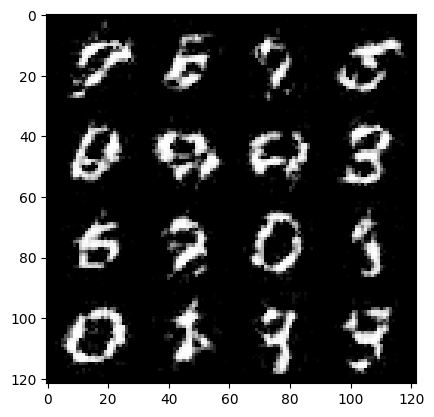

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2    Disc Loss : 0.579980613961657     Gen Loss : 0.846291294102984


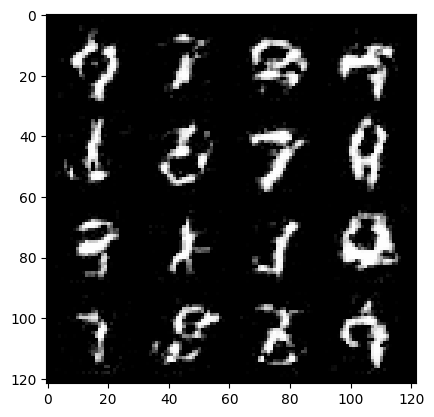

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3    Disc Loss : 0.5439718384732569     Gen Loss : 0.9197405302194136


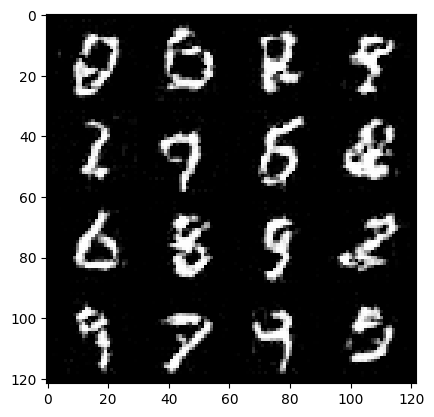

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4    Disc Loss : 0.5209378065076719     Gen Loss : 0.9821253432902192


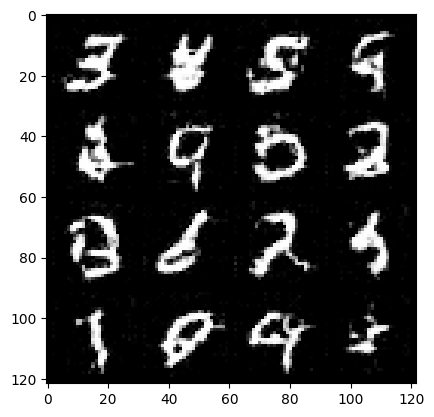

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5    Disc Loss : 0.5117415100145442     Gen Loss : 1.0263159905415353


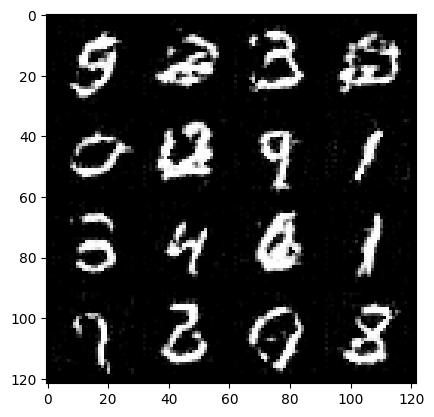

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6    Disc Loss : 0.5097952288732346     Gen Loss : 1.0578493874972816


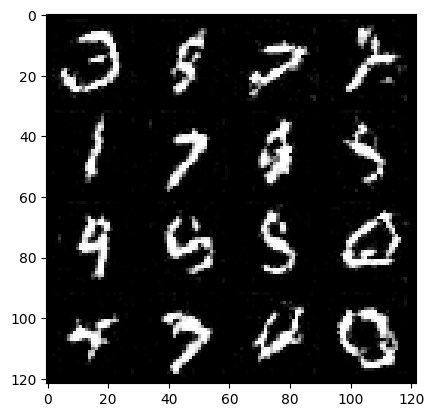

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7    Disc Loss : 0.5177261398545207     Gen Loss : 1.0648390845195064


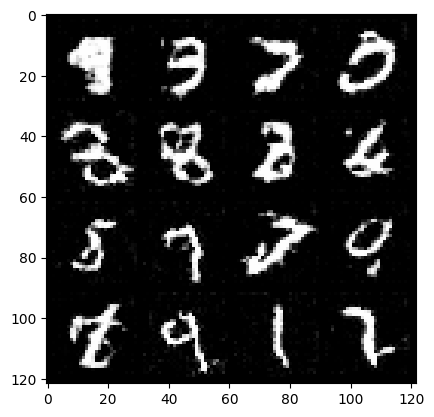

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8    Disc Loss : 0.529756616872511     Gen Loss : 1.0651083851673964


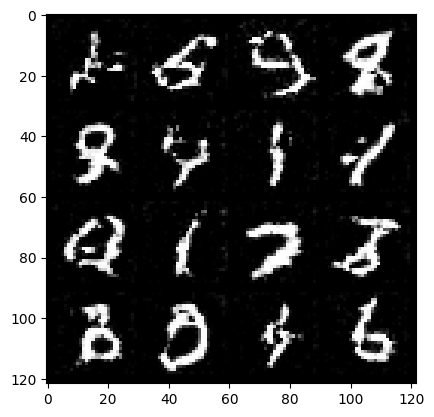

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9    Disc Loss : 0.5436514523237753     Gen Loss : 1.0509195819592425


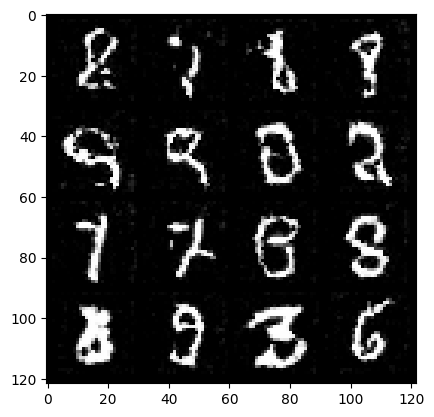

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10    Disc Loss : 0.5581609337314614     Gen Loss : 1.03606922959468


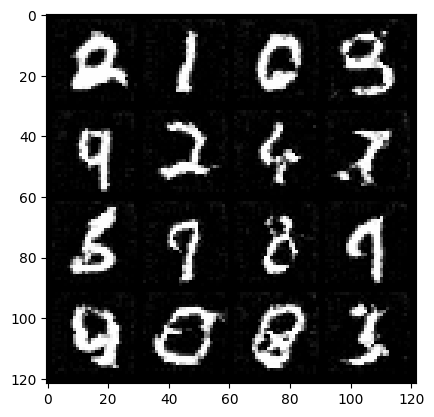

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11    Disc Loss : 0.5669232662806887     Gen Loss : 1.0244375419006673


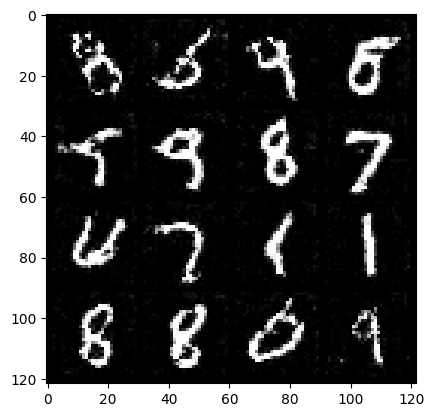

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12    Disc Loss : 0.5729565486979129     Gen Loss : 1.014940511061947


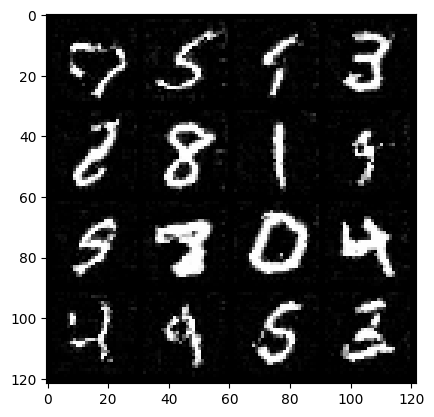

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13    Disc Loss : 0.5803977332389685     Gen Loss : 1.0057925720458853


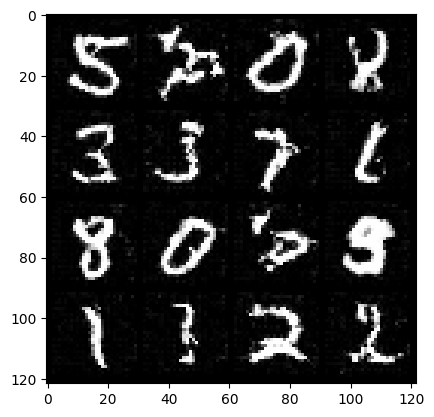

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14    Disc Loss : 0.5856938139716191     Gen Loss : 0.99681031068505


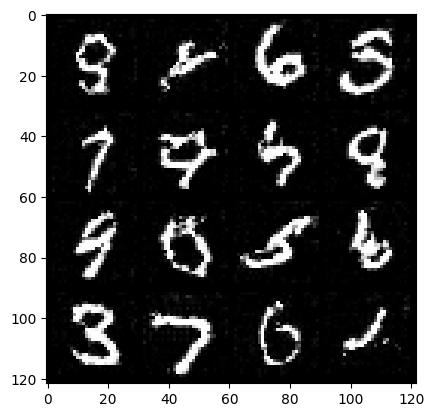

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15    Disc Loss : 0.5898135539565259     Gen Loss : 0.993541670379354


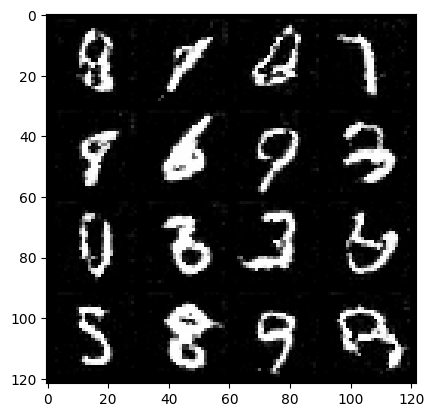

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16    Disc Loss : 0.5928954166898341     Gen Loss : 0.9879408866357702


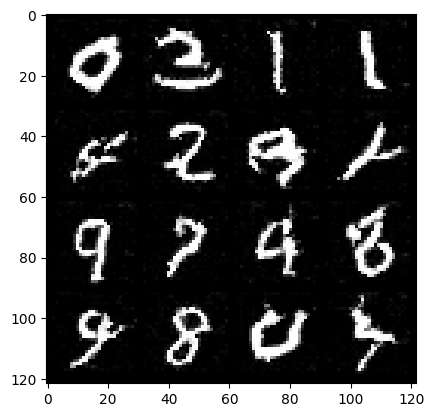

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17    Disc Loss : 0.5977530745046733     Gen Loss : 0.9785731551743774


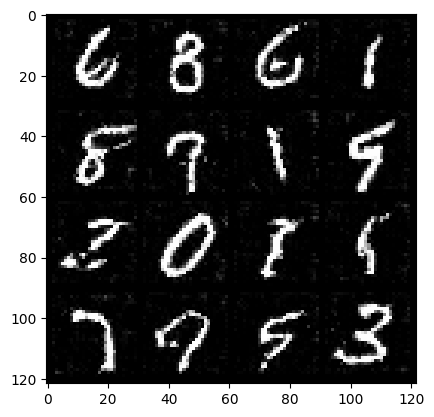

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18    Disc Loss : 0.5992465447515313     Gen Loss : 0.9779532281066309


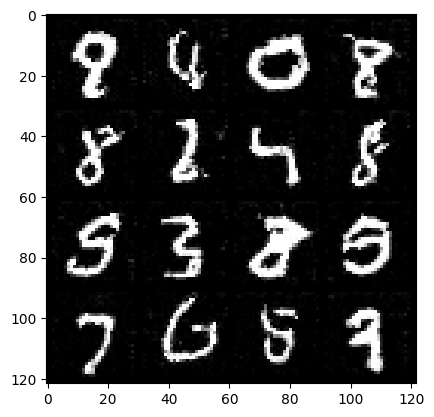

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19    Disc Loss : 0.6015326509089358     Gen Loss : 0.971632591442767


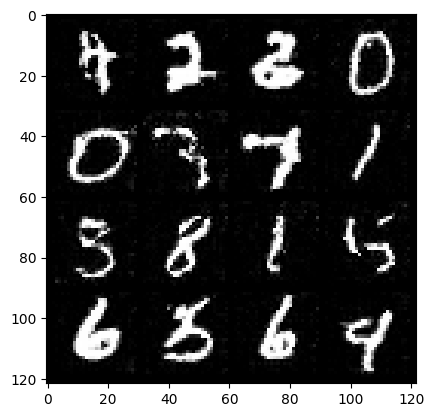

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20    Disc Loss : 0.6023648382504103     Gen Loss : 0.9695483355888171


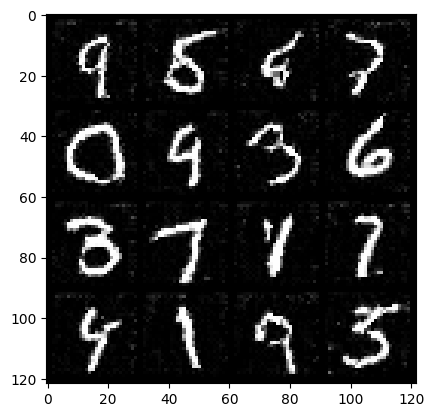

In [ ]:
# remember "tqdm" is used to add the progression of loop

for i in range(EPOCHS):
  total_disc_loss = 0.0
  total_gen_loss = 0.0

  for real_img,_ in tqdm(trainloader):
    real_img = real_img.to(DEVICE)
    noise = torch.randn(BATCH_SIZE, NOISE_DIM, device = DEVICE)

    # find loss and update weights for discriminator model
    discriminator_optimizer.zero_grad()
    # fake loss
    fake_img = generator(noise)
    disc_pred = discriminator(fake_img)
    disc_fake_loss = fake_loss(disc_pred)
    # real loss
    disc_pred = discriminator(real_img)
    disc_real_loss = real_loss(disc_pred)
    # for total loss we will take average of both models and then add it to total one
    disc_loss = (disc_fake_loss + disc_real_loss)/ 2
    total_disc_loss += disc_loss.item()
    # finding grads and updating the parameter
    disc_loss.backward()
    discriminator_optimizer.step()

    # find loss and update weights for Generator model
    generator_optimizer.zero_grad()
    # total loss
    fake_img = generator(noise)
    disc_pred = discriminator(fake_img)
    gen_loss = real_loss(disc_pred)
    total_gen_loss += gen_loss.item()
    # finding grads and updating the parameter
    gen_loss.backward()
    generator_optimizer.step()

  # now we are going to print exact loss of both models
  avg_disc_loss = total_disc_loss / len(trainloader)
  avg_gen_loss = total_gen_loss / len(trainloader)

  print(f"Epoch : {i+1}    Disc Loss : {avg_disc_loss}     Gen Loss : {avg_gen_loss}")
  show_tensor_images(fake_img)

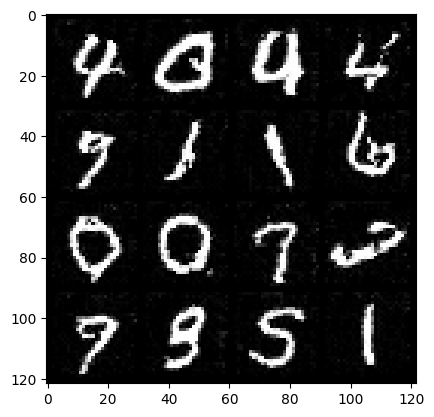

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(BATCH_SIZE, NOISE_DIM, device = DEVICE)
generated_image = generator(noise)

show_tensor_images(generated_image)